<a href="https://colab.research.google.com/github/appsstuff/006962/blob/master/Replicas_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------
# Step 1: Setup & Imports
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from google.colab import drive
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

# For visualization
from IPython.display import display, HTML
from tabulate import tabulate

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


In [ ]:

# -----------------------------
# Step 2: Mount Google Drive
# -----------------------------
drive.mount('/content/drive')
MODEL_DIR= "/content/drive/MyDrive/Autoscale/"
os.makedirs(MODEL_DIR, exist_ok=True)

print("✅ Google Drive mounted and model directory created.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted and model directory created.


In [ ]:

# -----------------------------
# Step 3: Load and Validate Data
# -----------------------------

correct_path = MODEL_DIR+'Workload_metrics_V2.csv'

df = pd.read_csv(correct_path)
df.columns = df.columns.str.strip()
# Optional: print column names
print("Available columns:", df.columns.tolist())

display(df.head())
display(df.describe().style.set_table_attributes("class='table table-striped'"))
display(df.isnull().sum().reset_index().rename(columns={'index':'Column',0:'Missing'}).style.set_table_attributes("class='table table-bordered'"))

# Check for missing values
if df.isnull().sum().any():
    print("⚠️ Missing values detected. Filling with forward fill...")
    df.fillna(method='ffill', inplace=True)

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

print("✅ Data loaded and preprocessed.")


Available columns: ['timestamp', 'requests', 'adservice_cpu', 'cartservice_cpu', 'checkoutservice_cpu', 'currencyservice_cpu', 'emailservice_cpu', 'frontend_cpu', 'paymentservice_cpu', 'productcatalogservice_cpu', 'recommendationservice_cpu', 'redis_cpu', 'shippingservice_cpu']


,timestamp,requests,adservice_cpu,cartservice_cpu,checkoutservice_cpu,currencyservice_cpu,emailservice_cpu,frontend_cpu,paymentservice_cpu,productcatalogservice_cpu,recommendationservice_cpu,redis_cpu,shippingservice_cpu
0,2025-06-14 10:48:00+00:00,9278,46,102.0,45.0,117.0,47.0,149,29,182,126,81.0,43.0
1,2025-06-14 10:49:00+00:00,9301,46,102.0,45.0,118.0,47.0,149,29,183,126,81.0,44.0
2,2025-06-14 10:50:00+00:00,9326,46,102.0,45.0,118.0,48.0,149,29,183,127,81.0,44.0
3,2025-06-14 10:51:00+00:00,9346,46,102.0,46.0,119.0,48.0,150,30,183,127,81.0,44.0
4,2025-06-14 10:52:00+00:00,9373,46,102.0,46.0,119.0,48.0,150,30,184,127,81.0,44.0


,requests,adservice_cpu,cartservice_cpu,checkoutservice_cpu,currencyservice_cpu,emailservice_cpu,frontend_cpu,paymentservice_cpu,productcatalogservice_cpu,recommendationservice_cpu,redis_cpu,shippingservice_cpu
count,5761.000000,5761.000000,5615.000000,5615.000000,5615.000000,5615.000000,5761.000000,5761.000000,5761.000000,5761.000000,5616.000000,5760.000000
mean,373217.012671,948.013539,2605.424577,1182.709528,3401.426714,462.827605,12028.107620,271.726784,4085.582191,2900.066308,609.899395,901.978125
std,445519.187040,1133.687987,3020.819159,1367.547103,3880.352176,441.281424,14551.920483,227.957387,4595.739909,3266.915196,571.206518,1017.927980
min,32.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,21330.000000,57.000000,181.000000,82.000000,216.000000,102.000000,396.000000,80.000000,437.000000,292.000000,140.000000,98.000000
50%,55694.000000,120.000000,515.000000,240.000000,771.000000,203.000000,1604.000000,146.000000,842.000000,592.000000,336.000000,204.000000
75%,736074.000000,1852.000000,5009.000000,2283.500000,6487.500000,823.000000,23595.000000,461.000000,7700.000000,5550.000000,1054.000000,1710.250000
max,1465729.000000,3539.000000,9456.000000,4269.000000,12261.000000,1430.000000,45216.000000,768.000000,14539.000000,10284.000000,1886.000000,3225.000000


,Column,Missing
0,timestamp,0
1,requests,0
2,adservice_cpu,0
3,cartservice_cpu,146
4,checkoutservice_cpu,146
5,currencyservice_cpu,146
6,emailservice_cpu,146
7,frontend_cpu,0
8,paymentservice_cpu,0
9,productcatalogservice_cpu,0


⚠️ Missing values detected. Filling with forward fill...
✅ Data loaded and preprocessed.


In [ ]:

# -----------------------------
# Step 4: Feature Engineering - Sequence Creation
# -----------------------------
WINDOW_SIZE = 60
PRED_HORIZON = 1

def create_sequences(data, window_size=60, pred_horizon=1):
    X, y = [], []
    for i in range(window_size, len(data) - pred_horizon):
        x_seq = data[i-window_size:i]
        y_seq = data[i+pred_horizon]
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, WINDOW_SIZE, PRED_HORIZON)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"✅ Created sequences: {X.shape}, Targets: {y.shape}")


✅ Created sequences: (5700, 60, 12), Targets: (5700, 12)


In [ ]:

# -----------------------------
# Step 5: Build LSTM Encoder
# -----------------------------
def build_lstm_encoder(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    return model

lstm_model = build_lstm_encoder((X.shape[1], X.shape[2]))
train_features = lstm_model.predict(X_train)
test_features = lstm_model.predict(X_test)


print("✅ LSTM encoder built and features extracted.")


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ LSTM encoder built and features extracted.


In [ ]:

# -----------------------------
# Step 6: Fit GPR on LSTM Features
# -----------------------------
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=5)
gpr.fit(train_features, y_train)

print("✅ Gaussian Process Regressor fitted.")


✅ Gaussian Process Regressor fitted.


In [19]:
# -----------------------------
# Step 7: Predict and Inverse Scale
# -----------------------------
y_pred, std = gpr.predict(test_features, return_std=True)

# Ensure std is 1D
std = std.ravel()

# Get number of services (targets), not total features
n_samples = y_pred.shape[0]
n_targets = y_pred.shape[1]  # Number of services (e.g., 11)
n_features = scaled_data.shape[1]  # Total features in original data (e.g., 12)

# Inverse scale predicted values
y_pred_original = np.zeros_like(y_pred)
for i in range(n_targets):
    dummy = np.zeros((n_samples, n_features))
    dummy[:, i] = y_pred[:, i].ravel()
    dummy_unscaled = scaler.inverse_transform(dummy)
    y_pred_original[:, i] = dummy_unscaled[:, i]

# Inverse scale true values
y_true_original = np.zeros_like(y_test)
for i in range(n_targets):
    dummy = np.zeros((y_test.shape[0], n_features))
    dummy[:, i] = y_test[:, i].ravel()
    dummy_unscaled = scaler.inverse_transform(dummy)
    y_true_original[:, i] = dummy_unscaled[:, i]

# Inverse scale uncertainty (std)
std_original = np.zeros_like(std)
for i in range(n_targets):  # Only loop over targets, not all features!
    dummy = np.zeros((1, n_features))
    dummy[0, i] = float(std[i])  # Safe assignment within bounds
    dummy_unscaled = scaler.inverse_transform(dummy)
    std_original[i] = dummy_unscaled[0, i]

print("✅ Predictions made and inverse scaled.")

✅ Predictions made and inverse scaled.


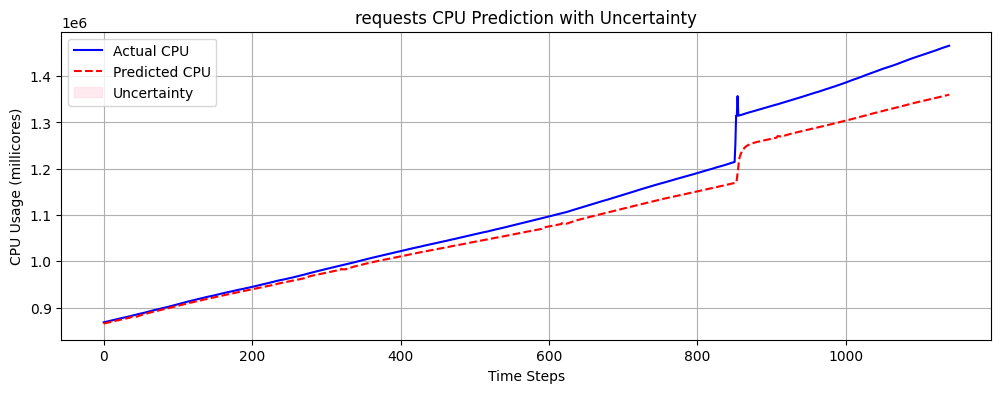

Shape of y_pred_original: (1140, 12)
Shape of std_original: (13680,)
Length of prediction: 1140


In [25]:
# Pick only the relevant std values for the service being plotted
service_idx = 0  # Index of the service you want to visualize (e.g., 'adservice_cpu')
# Choose which service to visualize by index

# Pick only the relevant std values for the service being plotted
std_for_service = std_original[:len(y_pred_original)]

plt.figure(figsize=(12, 4))
plt.plot(y_true_original[:, service_idx], label="Actual CPU", color='blue')
plt.plot(y_pred_original[:, service_idx], label="Predicted CPU", color='red', linestyle="--")
plt.fill_between(
    range(len(y_pred_original)),
    y_pred_original[:, service_idx] - std_for_service,
    y_pred_original[:, service_idx] + std_for_service,
    color='pink', alpha=0.3, label="Uncertainty"
)
plt.title(f"{df.columns[service_idx]} CPU Prediction with Uncertainty")
plt.xlabel("Time Steps")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.grid(True)
plt.show()
print("Shape of y_pred_original:", y_pred_original.shape)
print("Shape of std_original:", std_original.shape)
print("Length of prediction:", len(y_pred_original))

In [26]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# -----------------------------
# Function: Plot by Service Name
# -----------------------------
def plot_prediction(service_name, y_true, y_pred, std, df_columns, show_plot=True):
    if service_name not in df_columns:
        raise ValueError(f"Service '{service_name}' not found in columns.")

    service_idx = df_columns.index(service_name)

    # Limit std to prediction length
    std_for_service = std[:len(y_pred)]

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(y_true[:, service_idx], label="Actual CPU", color='blue')
    ax.plot(y_pred[:, service_idx], label="Predicted CPU", color='red', linestyle="--")
    ax.fill_between(
        range(len(y_pred)),
        y_pred[:, service_idx] - std_for_service,
        y_pred[:, service_idx] + std_for_service,
        color='pink', alpha=0.3, label="Uncertainty"
    )
    ax.set_title(f"{service_name} CPU Prediction with Uncertainty")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("CPU Usage (millicores)")
    ax.legend()
    ax.grid(True)

    # Save to buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    data = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()

    if show_plot:
        display(HTML(f'<img src="data:image/png;base64,{data}">'))

    return f'<h3>{service_name}</h3><img src="data:image/png;base64,{data}"><br>'

# -----------------------------
# Plot All Services
# -----------------------------
def plot_all_predictions(df_columns, y_true, y_pred, std):
    html_report = "<h1>📊 CPU Prediction Report for All Services</h1>\n"
    for service_name in df_columns:
        print(f"📈 Plotting {service_name}...")
        html_report += plot_prediction(service_name, y_true, y_pred, std, df_columns, show_plot=False)
    return html_report

# -----------------------------
# Generate and Save HTML Report
# -----------------------------
html_content = plot_all_predictions(df.columns.tolist(), y_true_original, y_pred_original, std_original)

# Save HTML to file
report_path = os.path.join(MODEL_DIR, "cpu_prediction_report.html")
with open(report_path, "w") as f:
    f.write(html_content)

print(f"\n📄 HTML report saved at: {report_path}")

📈 Plotting requests...
📈 Plotting adservice_cpu...
📈 Plotting cartservice_cpu...
📈 Plotting checkoutservice_cpu...
📈 Plotting currencyservice_cpu...
📈 Plotting emailservice_cpu...
📈 Plotting frontend_cpu...
📈 Plotting paymentservice_cpu...
📈 Plotting productcatalogservice_cpu...
📈 Plotting recommendationservice_cpu...
📈 Plotting redis_cpu...
📈 Plotting shippingservice_cpu...

📄 HTML report saved at: /content/drive/MyDrive/Autoscale/cpu_prediction_report.html


In [27]:

# -----------------------------
# Step 8: Evaluate Model
# -----------------------------
mae = mean_absolute_error(y_true_original, y_pred_original)
mse = mean_squared_error(y_true_original, y_pred_original)
r2 = r2_score(y_true_original, y_pred_original)

eval_table = [
    ["MAE", mae],
    ["MSE", mse],
    ["R² Score", r2]
]

print("\n📈 Model Evaluation:")
print(tabulate(eval_table, headers=["Metric", "Value"], tablefmt="grid"))



📈 Model Evaluation:
+----------+----------------+
| Metric   |          Value |
+==========+================+
| MAE      | 2973.68        |
+----------+----------------+
| MSE      |    1.81387e+08 |
+----------+----------------+
| R² Score |    0.934577    |
+----------+----------------+


In [28]:

# -----------------------------
# Step 9: Estimate Replicas
# -----------------------------
POD_CPU_LIMIT_MILLICORES = 250

def estimate_replicas(cpu_usage_array, pod_limit=250):
    return np.ceil(cpu_usage_array / pod_limit).astype(int)

predicted_replicas = estimate_replicas(y_pred_original, POD_CPU_LIMIT_MILLICORES)
true_replicas = estimate_replicas(y_true_original, POD_CPU_LIMIT_MILLICORES)

print("\n🧮 Sample Replica Prediction:")
for i, col in enumerate(df.columns):
    print(f"{col}: Predicted={predicted_replicas[0][i]:.0f} | Actual={true_replicas[0][i]:.0f}")

# --------------------


🧮 Sample Replica Prediction:
requests: Predicted=3463 | Actual=3474
adservice_cpu: Predicted=9 | Actual=9
cartservice_cpu: Predicted=24 | Actual=24
checkoutservice_cpu: Predicted=11 | Actual=11
currencyservice_cpu: Predicted=32 | Actual=33
emailservice_cpu: Predicted=4 | Actual=4
frontend_cpu: Predicted=113 | Actual=113
paymentservice_cpu: Predicted=2 | Actual=2
productcatalogservice_cpu: Predicted=37 | Actual=37
recommendationservice_cpu: Predicted=26 | Actual=26
redis_cpu: Predicted=5 | Actual=5
shippingservice_cpu: Predicted=9 | Actual=9


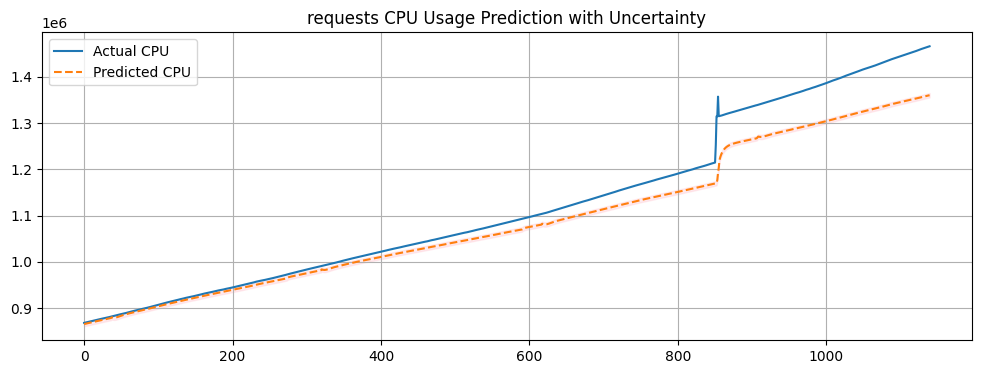

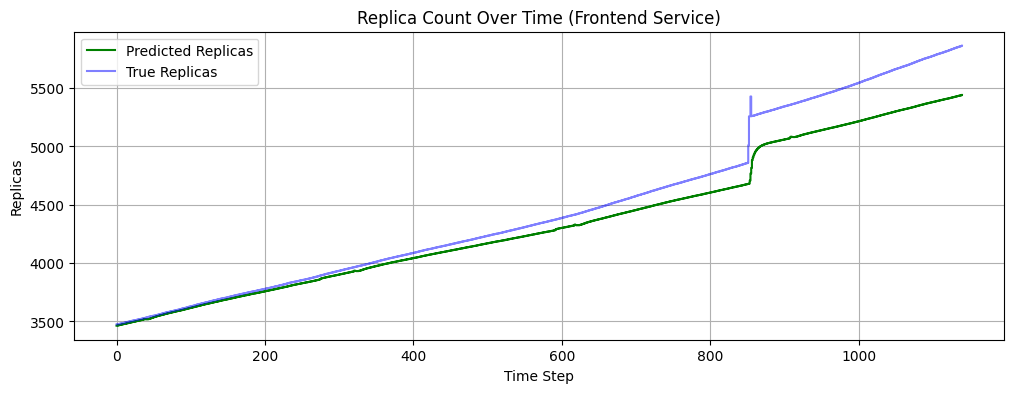

In [30]:

# -----------------------------
# Step 10: Visualization
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(y_true_original[:, 0], label="Actual CPU")
plt.plot(y_pred_original[:, 0], label="Predicted CPU", linestyle="--")
plt.fill_between(range(len(y_pred)), y_pred_original[:, 0] - std_original[0],
                 y_pred_original[:, 0] + std_original[0], color='pink', alpha=0.3)
plt.title(f"{df.columns[0]} CPU Usage Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot Replica Count Over Time
# -----------------------------
plt.figure(figsize=(12, 4))
x = range(len(predicted_replicas))

plt.step(x=x, y=predicted_replicas[:, 0], where='post', label="Predicted Replicas", color='green')
plt.step(x=x, y=true_replicas[:, 0], where='post', label="True Replicas", color='blue', alpha=0.5)

plt.title("Replica Count Over Time (Frontend Service)")
plt.xlabel("Time Step")
plt.ylabel("Replicas")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from IPython.display import display, HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# -----------------------------
# Function: Generate Evaluation Metrics
# -----------------------------
def evaluate_model(y_true, y_pred):
    metrics = {
        "Metric": ["MAE", "MSE", "RMSE", "R² Score", "Explained Variance"],
        "Value": [
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred)),
            r2_score(y_true, y_pred),
            explained_variance_score(y_true, y_pred)
        ]
    }
    return pd.DataFrame(metrics)

# -----------------------------
# Function: Display DataFrame as HTML Table with Styling
# -----------------------------
def display_html_table(df, title="Model Evaluation"):
    html = f"<h2>{title}</h2>"
    html += df.to_html(index=False, float_format="%.4f")
    html += "<style>table {border-collapse: collapse; width: 60%; margin: auto;} " \
            "th, td {padding: 10px; text-align: center; border: 1px solid #ccc;} " \
            "th {background-color: #f2f2f2;}</style>"
    display(HTML(html))

# -----------------------------
# Example Usage (after prediction step)
# -----------------------------

# Evaluate predictions
df_metrics = evaluate_model(y_true_original, y_pred_original)

# Show HTML-styled table
display_html_table(df_metrics, title="📊 Model Performance Summary")

# Optional: Print sample replica comparison
print("\n🧮 Sample Replica Prediction:")
for i, col in enumerate(df.columns):
    print(f"{col}: Predicted={predicted_replicas[0][i]} | Actual={true_replicas[0][i]}")

Metric,Value
MAE,2973.6783
MSE,181387065.8428
RMSE,13468.0016
R² Score,0.9346
Explained Variance,0.9788



🧮 Sample Replica Prediction:
requests: Predicted=3463 | Actual=3474
adservice_cpu: Predicted=9 | Actual=9
cartservice_cpu: Predicted=24 | Actual=24
checkoutservice_cpu: Predicted=11 | Actual=11
currencyservice_cpu: Predicted=32 | Actual=33
emailservice_cpu: Predicted=4 | Actual=4
frontend_cpu: Predicted=113 | Actual=113
paymentservice_cpu: Predicted=2 | Actual=2
productcatalogservice_cpu: Predicted=37 | Actual=37
recommendationservice_cpu: Predicted=26 | Actual=26
redis_cpu: Predicted=5 | Actual=5
shippingservice_cpu: Predicted=9 | Actual=9


In [31]:

# -----------------------------
# Step 11: Save Model and Restore
# -----------------------------
# Save LSTM encoder
lstm_path = os.path.join(MODEL_DIR, 'lstm_encoder.h5')
lstm_model.save(lstm_path)

# Save GPR
gpr_path = os.path.join(MODEL_DIR, 'gpr_model.pkl')
with open(gpr_path, 'wb') as f:
    pickle.dump(gpr, f)

# Save Scaler
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n💾 Models saved to: {MODEL_DIR}")

# Restore example
try:
    restored_lstm = load_model(lstm_path)
    with open(gpr_path, 'rb') as f:
        restored_gpr = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        restored_scaler = pickle.load(f)
    print("✅ Models restored successfully.")
except Exception as e:
    print(f"❌ Error restoring model: {e}")

# -----------------------------
# Step 12: Generate HTML Report
# -----------------------------
html_report = f"""
<h1>🧠 Kubernetes Replica Prediction Report</h1>
<h2>📉 Model Evaluation</h2>
<table border="1" class="dataframe">
  <thead><tr style="text-align: right;"><th>Metric</th><th>Value</th></tr></thead>
  <tbody>
    <tr><td>MAE</td><td>{mae:.4f}</td></tr>
    <tr><td>MSE</td><td>{mse:.4f}</td></tr>
    <tr><td>R² Score</td><td>{r2:.4f}</td></tr>
  </tbody>
</table>

<h2>🧮 Sample Prediction</h2>
<ul>
{''.join([f'<li>{df.columns[i]}: Predicted={predicted_replicas[0][i]} | Actual={true_replicas[0][i]}</li>' for i in range(len(df.columns))])}
</ul>
"""

with open(os.path.join(MODEL_DIR, "report.html"), "w") as f:
    f.write(html_report)

print("📄 HTML report generated.")

# -----------------------------
# Final Message
# -----------------------------
print("\n✅ All steps completed. You can find results in your Google Drive.")


💾 Models saved to: /content/drive/MyDrive/Autoscale/
✅ Models restored successfully.
📄 HTML report generated.

✅ All steps completed. You can find results in your Google Drive.
